# Automatic Ticket Classification Case Study

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
pip install swifter

In [3]:
# Import necessary libraries
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load(disable=['parser','ner'])
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import swifter
from sklearn.feature_extraction.text import TfidfTransformer

%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [4]:
# Opening JSON file 
f = open('complaints-2021-05-14_08_16.json')
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [5]:
# Inspect the dataframe to understand the given data.
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [6]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [7]:
#Assign new column names
df.rename(columns={'_source.complaint_what_happened':'complaints_what_happened', '_source.product':'tag'}, inplace=True)

In [8]:
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', 'tag',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely', 'complaints_what_happened',
       '_source.sub_issue', '_source.consumer_consent_provided'],
      dtype='object')

In [9]:
df = df[['complaints_what_happened', 'tag']]

In [10]:
df = df[df['complaints_what_happened'].astype(bool)]
df

,complaints_what_happened,tag
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card
10,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o..."
11,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o..."
14,my grand son give me check for {$1600.00} i de...,Checking or savings account
...,...,...
78303,After being a Chase Card customer for well ove...,Credit card or prepaid card
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Credit card or prepaid card
78310,I am not familiar with XXXX pay and did not un...,Checking or savings account
78311,I have had flawless credit for 30 yrs. I've ha...,Credit card or prepaid card


## Prepare the text for topic modeling

After removing blank complaints:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


After all the cleaning operations, performed the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [11]:
# Function to clean the text and remove all the unnecessary elements.
def clean_data(text):
    text = text.lower() # text to lowercase
    text = re.sub(r'\s\{\$\S*', '',text) # Remove text within curly braces
    text = re.sub(r'\n', '', text) # Remove line breaks
    text = re.sub(r'\(\w*\)', '', text) #remove text within braces
    text = re.sub(r'(\W\s)|(\W$)|(\W\d*)', ' ',text) # Remove punctuation
    text = re.sub(r'x+((/xx)*/\d*\s*)|x*', '',text) #Remove date
    text = re.sub(r'\d+\s', '', text) #Remove other numerical values
    text = re.sub(r' +', ' ',text) #Remove unnecessary white spaces
    return text


In [12]:
# Apply data cleaning to the complaints_what_happened column

df['complaints'] = df['complaints_what_happened'].apply(clean_data)
df.head()

,complaints_what_happened,tag,complaints
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,good morning my name is and i appreciate it if...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,i upgraded my card in and was told by the agen...
10,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o...",chase card was reported on however fraudulent ...
11,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o...",on while trying to book a ticket i came across...
14,my grand son give me check for {$1600.00} i de...,Checking or savings account,my grand son give me check for i deposit it in...


In [13]:
# Function to Lemmatize the texts
def lemmatization(text):
    tokens = word_tokenize(text)
    wordnet_lemmetizer = WordNetLemmatizer()
    lemmatized = [wordnet_lemmetizer.lemmatize(token) for token in tokens]
    lemmatized_str = " ".join(lemmatized)
    return lemmatized_str

In [14]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame({'complaints':df['complaints'], 'lemmatized':df['complaints'].apply(lemmatization)})

In [15]:
df_clean.head()

,complaints,lemmatized
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...


In [16]:
#Write your function to extract the POS tags 

def get_pos_tags(text):
    nn_words = []
    doc = nlp(text)
    for tok in doc:
        if(tok.tag_ == 'NN'):
            nn_words.append(tok.lemma_)
    nn_words_str = " ".join(nn_words)
    return nn_words_str

#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] =  df_clean.swifter.apply(lambda x: get_pos_tags(x['lemmatized']), axis=1)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [17]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaints,lemmatized,complaint_POS_removed
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop debt verification statement ...
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent wa informati...
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...
...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...
78309,on wednesday i called chas my visa credit card...,on wednesday i called chas my visa credit card...,visa credit card provider claim purchase prote...
78310,i am not familiar with pay and did not underst...,i am not familiar with pay and did not underst...,pay risk consumer chase bank app chase year ba...
78311,i have had flawless credit for yrs i ve had ch...,i have had flawless credit for yr i ve had cha...,credit yr credit card chase freedom problem ba...


## Exploratory data analysis to get familiar with the data.

Data visulaisation:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




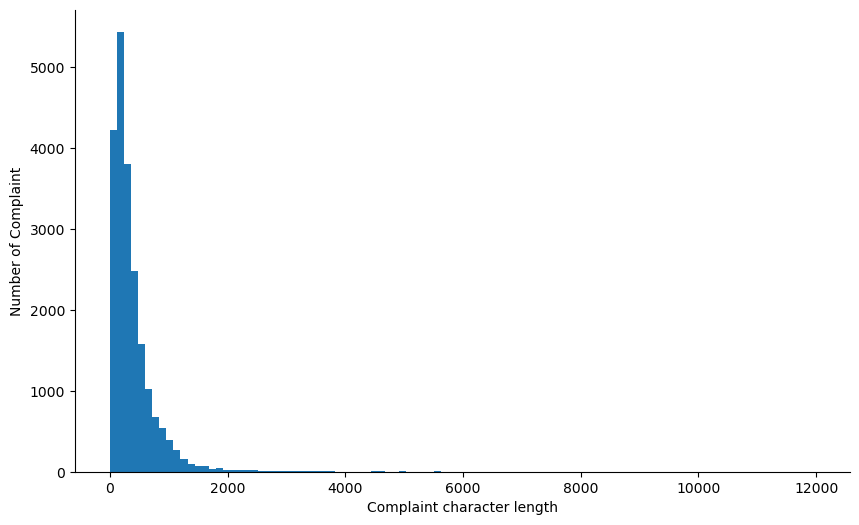

In [18]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.complaint_POS_removed]
plt.hist(doc_lens, bins = 100)
plt.ylabel('Number of Complaint')
plt.xlabel('Complaint character length')
sns.despine();

#### Find the top 40 words by frequency among all the articles after processing the text.

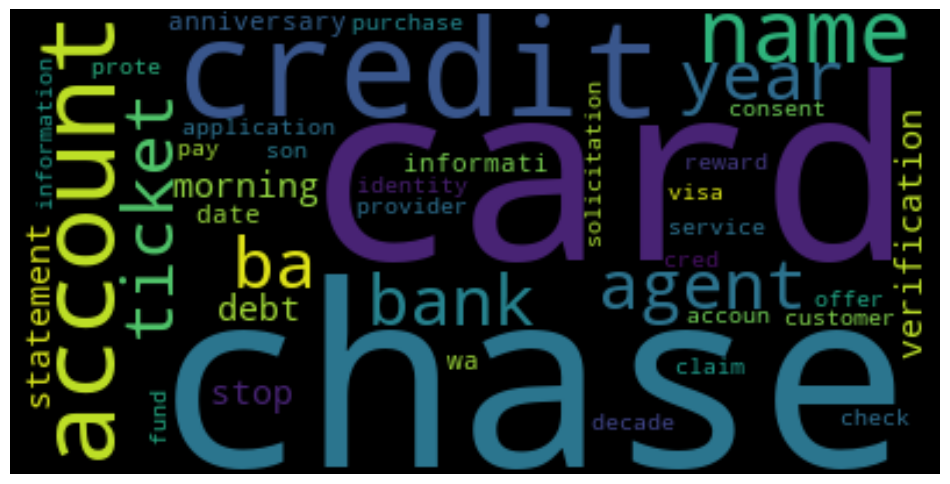

In [19]:
# Top 40 words frequency wise wordcloud
wordcloud = WordCloud(max_words=40, random_state=1, stopwords=set(STOPWORDS))
wordcloud.generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [20]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
df_clean

,complaints,lemmatized,complaint_POS_removed,Complaint_clean
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop debt verification statement ...,morning name stop debt verification statement ...
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent wa informati...,card agent anniversary date agent wa informati...
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,on wednesday i called chas my visa credit card...,on wednesday i called chas my visa credit card...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...
78310,i am not familiar with pay and did not underst...,i am not familiar with pay and did not underst...,pay risk consumer chase bank app chase year ba...,pay risk consumer chase bank app chase year ba...
78311,i have had flawless credit for yrs i ve had ch...,i have had flawless credit for yr i ve had cha...,credit yr credit card chase freedom problem ba...,credit yr credit card chase freedom problem ba...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [22]:
def top_grams(grams):
    c_vec = CountVectorizer(stop_words=stopwords.words('english'), ngram_range=(grams, grams))
    grams = c_vec.fit_transform(df_clean['complaints'])
    
    # Use sparse matrix methods to calculate column sums
    count_values = grams.sum(axis=0).A1
    vocab = c_vec.vocabulary_
    
    df_ngram = pd.DataFrame(
        sorted([(count_values[i], k) for k, i in vocab.items()], reverse=True)
    ).rename(columns={0: 'frequency', 1: 'ngram'})
    
    return df_ngram

In [23]:
df_unigram = top_grams(1)
df_unigram.head(10)

,frequency,ngram
0,80853,chase
1,42751,account
2,32812,credit
3,26946,card
4,26765,bank
5,20364,would
6,16383,told
7,14127,payment
8,13477,called
9,12877,received


In [24]:
df_bigram = top_grams(2)
df_bigram.head(10)

,frequency,ngram
0,12734,chase bank
1,10941,credit card
2,3709,called chase
3,3569,checking account
4,3253,credit report
5,3021,customer service
6,2714,jp morgan
7,2567,morgan chase
8,2534,chase credit
9,1997,account chase


In [25]:
df_trigram = top_grams(3)
df_trigram.head(10)

,frequency,ngram
0,2230,jp morgan chase
1,1982,chase credit card
2,773,credit card company
3,692,morgan chase bank
4,666,credit card account
5,560,chase customer service
6,554,account chase bank
7,552,credit card chase
8,457,received letter chase
9,438,called chase bank


In [26]:
df_clean

,complaints,lemmatized,complaint_POS_removed,Complaint_clean
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop debt verification statement ...,morning name stop debt verification statement ...
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent wa informati...,card agent anniversary date agent wa informati...
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,on wednesday i called chas my visa credit card...,on wednesday i called chas my visa credit card...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...
78310,i am not familiar with pay and did not underst...,i am not familiar with pay and did not underst...,pay risk consumer chase bank app chase year ba...,pay risk consumer chase bank app chase year ba...
78311,i have had flawless credit for yrs i ve had ch...,i have had flawless credit for yr i ve had cha...,credit yr credit card chase freedom problem ba...,credit yr credit card chase freedom problem ba...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [27]:
#Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [28]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['complaints'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task we will perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [29]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
We need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good our final topics are.

In [30]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(random_state=40, n_components=num_topics)

In [31]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

14985

In [32]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names_out())
topic_words_df = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)

for i in range(num_topics):
    ix = nmf_model.components_[i].argsort()[::-1][:15]
    topic_words_df.iloc[i] = words[ix]

topic_words_df

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,card,chase,charges,charge,dispute,fraud,called,received,did,told,merchant,claim,transaction,said,refund
Topic 2,credit,card,report,inquiry,chase,inquiries,hard,cards,reporting,score,accounts,account,closed,debt,removed
Topic 3,loan,mortgage,chase,home,modification,property,foreclosure,payments,house,bank,years,sale,morgan,rate,jp
Topic 4,account,bank,check,chase,money,funds,checking,closed,deposit,branch,told,accounts,deposited,said,business
Topic 5,payment,late,payments,balance,paid,pay,month,fees,fee,statement,auto,account,chase,charged,monthly


In [33]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)
topic_results.argmax(axis=1)

array([2, 0, 1, ..., 0, 4, 4], dtype=int64)

In [34]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_results.argmax(axis=1)

In [35]:
df_clean.head()

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,2
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent wa informati...,card agent anniversary date agent wa informati...,0
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...,1
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,1
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,3


In [36]:
# Print the first 5 Complaint for each of the Topics
First5_comp=df_clean.groupby('Topic').head(5)
First5_comp.sort_values('Topic')

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent wa informati...,card agent anniversary date agent wa informati...,0
21,on i made a payment to an online retailer usin...,on i made a payment to an online retailer usin...,payment retailer chase pay chase website scam ...,payment retailer chase pay chase website scam ...,0
43,chase sent me an email today with the innocuou...,chase sent me an email today with the innocuou...,chase email today title information change cha...,chase email today title information change cha...,0
40,a sofa love seat table and chairs and was nev...,a sofa love seat table and chair and wa never ...,sofa love seat table chair debit card bank vis...,sofa love seat table chair debit card bank vis...,0
32,my chase amazon card was declined for a cateri...,my chase amazon card wa declined for a caterin...,chase amazon card catering order brother funer...,chase amazon card catering order brother funer...,0
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...,1
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,1
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
23,i have a chase credit card which is incorrectl...,i have a chase credit card which is incorrectl...,credit card credit report company issue,credit card credit report company issue,1
26,i have reached out to several times in attempt...,i have reached out to several time in attempt ...,time attempt inquiry creditor inquiry report a...,time attempt inquiry creditor inquiry report a...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [37]:
# Create the dictionary of Topic names and Topics
Topic_names = {0:'Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}

# Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [38]:
df_clean

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,Mortgage/Loan
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent wa informati...,card agent anniversary date agent wa informati...,Account Services
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...,Others
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,Others
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,Credit card or prepaid card
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,Others
78309,on wednesday i called chas my visa credit card...,on wednesday i called chas my visa credit card...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...,Account Services
78310,i am not familiar with pay and did not underst...,i am not familiar with pay and did not underst...,pay risk consumer chase bank app chase year ba...,pay risk consumer chase bank app chase year ba...,Account Services
78311,i have had flawless credit for yrs i ve had ch...,i have had flawless credit for yr i ve had cha...,credit yr credit card chase freedom problem ba...,credit yr credit card chase freedom problem ba...,Theft/Dispute Reporting


## Supervised model to predict any new complaints to the relevant Topics.

We have built a model to create the topics for each complaints.Now in the below section we will use them to classify any new complaints.

*Since we will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)*

In [39]:
# Create the dictionary again of Topic names and Topics

Topic_names = {'Account Services':0, 'Others':1, 'Mortgage/Loan':2, 'Credit card or prepaid card':3, 'Theft/Dispute Reporting':4}
# Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [40]:
df_clean

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,2
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent wa informati...,card agent anniversary date agent wa informati...,0
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...,1
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,1
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,3
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,1
78309,on wednesday i called chas my visa credit card...,on wednesday i called chas my visa credit card...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...,0
78310,i am not familiar with pay and did not underst...,i am not familiar with pay and did not underst...,pay risk consumer chase bank app chase year ba...,pay risk consumer chase bank app chase year ba...,0
78311,i have had flawless credit for yrs i ve had ch...,i have had flawless credit for yr i ve had cha...,credit yr credit card chase freedom problem ba...,credit yr credit card chase freedom problem ba...,4


In [41]:
# Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean.drop(['lemmatized', 'complaint_POS_removed', 'Complaint_clean'], axis=1)

In [42]:
training_data

,complaints,Topic
1,good morning my name is and i appreciate it if...,2
2,i upgraded my card in and was told by the agen...,0
10,chase card was reported on however fraudulent ...,1
11,on while trying to book a ticket i came across...,1
14,my grand son give me check for i deposit it in...,3
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday i called chas my visa credit card...,0
78310,i am not familiar with pay and did not underst...,0
78311,i have had flawless credit for yrs i ve had ch...,4


#### Applying the supervised models on the training data created. In this process, we are going to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [43]:
# Write your code to get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.complaints)

# Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report

In [45]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.2, random_state=42)

**1. Logistic Regression**

In [46]:
# Logistic Regression
lr = LogisticRegression().fit(X_train, y_train)
predicted = lr.predict(X_test)

print(classification_report(y_true=y_test, y_pred=predicted))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       944
           1       0.96      0.95      0.96       914
           2       0.98      0.95      0.96       714
           3       0.94      0.97      0.96      1123
           4       0.97      0.90      0.93       520

    accuracy                           0.95      4215
   macro avg       0.96      0.95      0.95      4215
weighted avg       0.95      0.95      0.95      4215



**2. Decision Tree**

In [47]:
# Decision tree classifier
dt = DecisionTreeClassifier().fit(X_train, y_train)
predicted = dt.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.74      0.72      0.73       944
           1       0.80      0.79      0.80       914
           2       0.80      0.82      0.81       714
           3       0.80      0.81      0.81      1123
           4       0.69      0.68      0.68       520

    accuracy                           0.77      4215
   macro avg       0.76      0.77      0.77      4215
weighted avg       0.77      0.77      0.77      4215



**3. Random Forest Classifier**

In [48]:
rfc = RandomForestClassifier(max_depth=10)
rfc.fit(X_train, y_train)
predicted = rfc.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.79      0.69      0.74       944
           1       0.74      0.76      0.75       914
           2       0.88      0.80      0.84       714
           3       0.62      0.97      0.76      1123
           4       1.00      0.12      0.22       520

    accuracy                           0.73      4215
   macro avg       0.81      0.67      0.66      4215
weighted avg       0.78      0.73      0.70      4215



**4. Gaussian Naive Bayes**

In [49]:
nb = GaussianNB().fit(X_train.toarray(), y_train)
predicted = nb.predict(X_test.toarray())

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.48      0.35      0.40       944
           1       0.35      0.27      0.30       914
           2       0.52      0.50      0.51       714
           3       0.46      0.30      0.37      1123
           4       0.18      0.51      0.27       520

    accuracy                           0.36      4215
   macro avg       0.40      0.38      0.37      4215
weighted avg       0.42      0.36      0.37      4215



**Clearly Logistic Regression is performing better**

### Infering the best model

In [57]:
# Some sample complaints to infer model

df_complaints = pd.DataFrame({'complaints': ["If I Pay some Lumpsum amout ,will my EMI reduce?",
	"Can I get credit of loan amount in Account other than mentioned on the  screen",
	"Can I enter a mobile number other than the one used for downloading the app.",
	"Can I avail 2 Pre-approved Loans",
	"Can FATCA status be updated later?",
	"Is the Interest rate  fixed or floating?",
	"Why I am not able to select loan amount below 25000?"]})
df_complaints

,complaints
0,"If I Pay some Lumpsum amout ,will my EMI reduce?"
1,Can I get credit of loan amount in Account oth...
2,Can I enter a mobile number other than the one...
3,Can I avail 2 Pre-approved Loans
4,Can FATCA status be updated later?
5,Is the Interest rate fixed or floating?
6,Why I am not able to select loan amount below ...


In [58]:
def predict_lr(text):
    Topic_names = {0:'Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}
    X_new_counts = count_vect.transform(text)
    X_new_tfidf = tfidf_transformer.transform(X_new_counts)
    predicted = lr.predict(X_new_tfidf)
    return Topic_names[predicted[0]]

In [59]:
df_complaints['tag'] = df_complaints['complaints'].apply(lambda x: predict_lr([x]))
df_complaints

,complaints,tag
0,"If I Pay some Lumpsum amout ,will my EMI reduce?",Mortgage/Loan
1,Can I get credit of loan amount in Account oth...,Others
2,Can I enter a mobile number other than the one...,Account Services
3,Can I avail 2 Pre-approved Loans,Mortgage/Loan
4,Can FATCA status be updated later?,Account Services
5,Is the Interest rate fixed or floating?,Mortgage/Loan
6,Why I am not able to select loan amount below ...,Mortgage/Loan


## Conclusion
    
* **As expected 5 topics were indetified namely:**
    1. Account Services
    2. Others
    3. Mortgage/Loan
    4. Credit card or prepaid card
    5. Theft/Dispute Reporting
    
    
* **Tried 4 models on the data with accuracies as follows:**

    | Model       | Accuracy |
    | ----------- | ----------- |
    | Logistic Regression      | 0.95       |
    | Decision Tree   | 0.77        |
    | Random Forest      | 0.74       |
    | Naive Bayes   | 0.36        |
    
 <br /> <br /> <br /> <br /><br /> <br /><br />
* **Logistic Regression has highest accuracy of `0.95`, Hence is a good fit for this particular case study.**